<a href="https://colab.research.google.com/github/joshuabdixon/Monte-Carlo-Simulation-Supply-Chain-Management/blob/main/Monte%20Carlo%20Simulation%20-%20Supply%20Chain%20Management.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Activity 1.3.3: Simulating random events using Python

## Supply Chain Management
- Supply chain management: Uncertainty in demand, transportation delays, and supply disruptions can impact the efficiency of supply chains, requiring optimisation and risk mitigation.

### **Problem Statement:**
 **Company A** faces significant uncertainties with product demand variability, transportation delays, and supply disruptions. To navigate these challenges, the company aims to use probability models to ensure it means inventory levels to meet daily demands for the next year.

 The strategic use of these models is expected to guide **Company A** in maintaining optimal inventory levels and mitigating risks associated with transportation delays and supply chain volatility.

 Ineffectively addressing these issues risks inventory misalignment with demand—either surplus leading to increased storage costs or deficits resulting in lost sales—each pathway potentially culminating in decreased revenue.

### Key Variables:
- Quantity in Stock: Current inventory levels for each product.
- Reorder Level: The predefined inventory level at which new orders should be placed.
- Unit Price: Cost per unit of product. It is assumed to be in GBP (£).
- Shipping Lead Time (days): Time taken for products to be delivered. A new order cannot be places if an existing order is on the way.
- Demand Forecast (Next Month): Projected customer demand for the upcoming month (Units of product predicted to be sold in the next month).

### Assumptions
- The data is assumed to be Normally Distributed
- Typically, there are 252 working days in a year, excluding weekends and bank holidays. The model will run for this duration.
- There are 21 working days in a month.
- The **Demand Forecast (Next Month)** variable is assumed to increase by 1% per month. This will be adjusted with the variable: *demand_forecast_growth_rate*.
- **Unit price** has been assumed to increase due to inflation by 2% per month with the variable: *unit_price_increase*
- A variance of 5% of the previous months demand forecast will be assumed with the variable:*demand_growth_variance*
- The unit price variance is equal to 5% of its current price with the variable: *unit_price_variance*
- **Shipping Lead Time (days)** is assumed to be an average based on Company A's historical data.
- **Shipping Lead Time (days)** has a variance of 1 day, with the variable: *lead_time_variance*
- **Order Quantity**: The order_quantity variable represents the order quantity, which is calculated via *daily_demand* x *mean_lead_time* x *reorder_buffer* (see next bullet point). This ensures there is enough stock to manage the demand during days leading up to the next order arrival date.
- **Reorder Buffer**: This variable has been introduced for added safety and reduce the risk of stockouts. The *reorder_buffer* variable has been set equal to 1.5 (50% more stock than required will be ordered).  
- It is assumed **Shipping Lead Time** is averaged or typical based on historical data for each product


### Monte-Carlo Model
- Over 252 business days, the Monte Carlo Simulation (MCS) evaluates inventory against demand.
- Demand and unit prices are recalculated every 21 days, incorporating a growth rate and variability.
- Reorders are placed when inventory drops below the set level, with lead time uncertainty accounted for by the MCS.
- Costs are based on current prices.
- After 200 runs, the MCS provides average stockout frequency and cost of the total inventory.


### Observations and Results
- Most products have an average stockout close to zero, either indicating effective inventory control or overstocking.
- There are outlier products with much higher average stockouts, which could indicate specific issues with those products that need addressing.

### Suggested implementations
- **For low-stockout products:** Evaluate if it's possible to reduce safety stock levels without significantly increasing stockout risk to free up capital.
- **For high-stockout products:** Investigate the reasons behind the frequent stockouts—consider improving demand forecasting, reviewing supplier performance, or adjusting the reorder level.
- **Cost Reduction:** Review procurement and logistics strategies to lower the total order cost, especially for products with high average total order costs.
- **Overall strategy:** Consider segmenting products based on their stockout profile and tailoring inventory strategies accordingly, such as implementing a more aggressive inventory reduction for stable-demand products and a robust inventory buffer for those with unpredictable demand.

# Monte Carlo Simulation

In [ ]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Set seed for reproducibility
np.random.seed(42)

# Set the simulation parameters
demand_forecast_growth_rate = 1.01
demand_forecast_variance = 0.15
unit_price_growth_rate = 1.02
unit_price_variance = 0.15
lead_time_variance = 1
lead_time_std = np.sqrt(lead_time_variance)
reorder_buffer = 1.5
num_days = 252  # Number of business days in a year
num_simulations = 200  # Number of simulation iterations
period = num_days + 1  # Period for the simulation, which includes the first day

In [ ]:
# Load and view the supply chain data
data1 = pd.read_csv("https://raw.githubusercontent.com/fourthrevlxd/cam_dsb/main/supply_chain_management_dataset.csv")
data1.head(5)

,Product ID,Product Name,Supplier ID,Supplier Name,Quantity in Stock,Reorder Level,Unit Price,Shipping Lead Time (days),Demand Forecast (Next Month)
0,P0001,Product 1,S7,Supplier 3,143,83,60.17,1,355
1,P0002,Product 2,S7,Supplier 12,253,82,78.70,5,39
2,P0003,Product 3,S9,Supplier 16,341,97,24.70,5,195
3,P0004,Product 4,S1,Supplier 3,489,77,161.27,7,223
4,P0005,Product 5,S1,Supplier 10,415,95,160.42,6,296


In [ ]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 9 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Product ID                    100 non-null    object 
 1   Product Name                  100 non-null    object 
 2   Supplier ID                   100 non-null    object 
 3   Supplier Name                 100 non-null    object 
 4   Quantity in Stock             100 non-null    int64  
 5   Reorder Level                 100 non-null    int64  
 6   Unit Price                    100 non-null    float64
 7   Shipping Lead Time (days)     100 non-null    int64  
 8   Demand Forecast (Next Month)  100 non-null    int64  
dtypes: float64(1), int64(4), object(4)
memory usage: 7.2+ KB


In [ ]:
# Define the Monte Carlo simulation function
def monte_carlo(row, period):
    """
    Perform a Monte Carlo simulation for supply chain management over a given period.

    This function simulates the inventory levels based on demand forecast growth, unit price variance,
    and shipping lead time variance. It places orders when the stock level falls below the reorder level
    and takes into account the lead time for the orders to arrive.

    Args:
      row (pd.Series): A pandas Series object representing a row from the dataframe.
      period (int): The number of days to run the simulation, typically set to the number of business days in a year.

    Returns:
      tuple: A tuple containing three elements:
             - An array representing the daily stock levels throughout the simulation period.
             - The total number of stockouts (int), i.e., days where the demand exceeds the stock level.
             - The total cost of orders (float) placed throughout the simulation period.
    """
    # Unpack necessary values from the row
    reorder_level = row['Reorder Level']
    lead_time = row['Shipping Lead Time (days)']
    current_demand_forecast = row['Demand Forecast (Next Month)']
    current_unit_price = row['Unit Price']

    # Initialise arrays to store stock levels and pending orders
    stock = np.zeros(period)
    stock[0] = row["Quantity in Stock"]
    pending_orders = np.zeros(period)

    # Initialise simulation variables
    order_in_transit = False
    scheduled_arrival_day = 0
    total_stockouts = 0
    total_order_cost = 0

   # Run the simulation for the specified period
    for day in range(1, period):
        # Update demand forecast and unit price every 21 days
        if day % 21 == 0:
            current_demand_forecast *= demand_forecast_growth_rate
            current_demand_forecast += np.random.normal(0, current_demand_forecast * demand_forecast_variance)
            current_demand_forecast = max(current_demand_forecast, 0)
            current_unit_price *= unit_price_growth_rate
            current_unit_price += np.random.normal(0, current_unit_price * unit_price_variance)
            current_unit_price = max(current_unit_price, 0)

        # Calculate daily demand
        daily_demand = current_demand_forecast / 21

        # Process pending orders and update stock levels
        if pending_orders[day] > 0:
            stock[day] = stock[day - 1] + pending_orders[day]
            if day == scheduled_arrival_day:
                order_in_transit = False
        else:
            stock[day] = stock[day - 1]

        # Decrease stock by daily demand and record stockouts
        stock[day] -= daily_demand
        if stock[day] < 0:
            stock[day] = 0
            total_stockouts += 1

        # Place new orders if below reorder level and no order is in transit
        if stock[day] < reorder_level and not order_in_transit:
            simulated_lead_time = int(np.random.normal(lead_time, lead_time_std))
            simulated_lead_time = max(simulated_lead_time, 1)
            arrival_day = day + simulated_lead_time
            if arrival_day < period:
                order_quantity = daily_demand * lead_time * reorder_buffer
                pending_orders[arrival_day] += order_quantity
                order_cost = order_quantity * current_unit_price
                total_order_cost += order_cost
                order_in_transit = True
                scheduled_arrival_day = arrival_day

    # Return the simulation results
    return stock, total_stockouts, total_order_cost

In [ ]:
# Run simulations for all products in the dataset
def run_simulations_for_all_products(data, num_simulations, period):
    """
    Run Monte Carlo simulations for each product in the dataset to evaluate inventory management performance.

    This function iterates through each product in the provided dataset and runs multiple Monte Carlo simulations
    to assess the effects of demand and supply variability on stock levels and ordering costs. It calculates the
    average number of stockouts and total order costs across all simulations for each product.

    Args:
      data (pd.DataFrame): The Supply Chain Management Data
      num_simulations (int): Number of Monte Carlo simulation iterations for each product.
      period (int): Number of days for each simulation iteration.

    Returns:
      dict: A dictionary with 'Product ID' as keys, each associated with another dictionary containing
            'average_num_of_stockouts' and 'average_total_order_cost' which are the computed averages of
            stockouts and order costs across simulations.
    """
    results = {}
    for index, row in data.iterrows():
        product_id = row['Product ID']
        total_stockouts_per_product = []
        total_order_costs_per_product = []

        # Run multiple simulations per product
        for simulation in range(num_simulations):
            _, total_stockouts, total_order_cost = monte_carlo(row, period)
            total_stockouts_per_product.append(total_stockouts)
            total_order_costs_per_product.append(total_order_cost)

        # Calculate average metrics per product
        average_num_of_stockouts = sum(total_stockouts_per_product) / num_simulations
        average_total_order_cost = sum(total_order_costs_per_product) / num_simulations
        results[product_id] = {
            'average_num_of_stockouts': average_num_of_stockouts,
            'average_total_order_cost': average_total_order_cost
        }

    return results

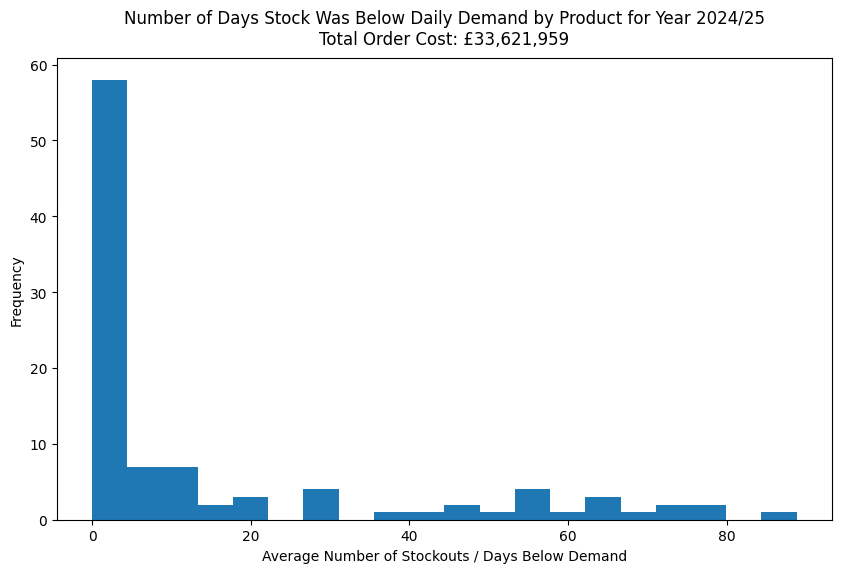

In [ ]:
# Run simulation and obtain results
simulation_results_for_all_products = run_simulations_for_all_products(data1, num_simulations, period)

# Plot the results in a histogram
average_stockouts = [stats['average_num_of_stockouts'] for stats in simulation_results_for_all_products.values()]
total_average_order_cost = sum(stats['average_total_order_cost'] for stats in simulation_results_for_all_products.values())

plt.figure(figsize=(10, 6))
plt.hist(average_stockouts, bins=20)
plt.title('Number of Days Stock Was Below Daily Demand by Product for Year 2024/25\n'
          f'Total Order Cost: £{total_average_order_cost:,.0f}', pad=10)
plt.xlabel('Average Number of Stockouts / Days Below Demand')
plt.ylabel('Frequency')
plt.show()


In [ ]:
for product_id, stats in simulation_results_for_all_products.items():
    print(f"Product: {product_id}")
    print(f"Average number of stockouts: {stats['average_num_of_stockouts']:.2f}")
    print(f"Average total order cost: £{stats['average_total_order_cost']:.2f}")
    print() # Added for clarity


Product: P0001
Average number of stockouts: 0.46
Average total order cost: £290525.46

Product: P0002
Average number of stockouts: 0.00
Average total order cost: £30517.71

Product: P0003
Average number of stockouts: 0.48
Average total order cost: £60258.11

Product: P0004
Average number of stockouts: 12.83
Average total order cost: £445058.28

Product: P0005
Average number of stockouts: 8.20
Average total order cost: £588505.01

Product: P0006
Average number of stockouts: 19.68
Average total order cost: £262137.78

Product: P0007
Average number of stockouts: 0.00
Average total order cost: £66965.26

Product: P0008
Average number of stockouts: 0.00
Average total order cost: £2840.69

Product: P0009
Average number of stockouts: 29.51
Average total order cost: £327632.76

Product: P0010
Average number of stockouts: 13.20
Average total order cost: £117768.59

Product: P0011
Average number of stockouts: 0.03
Average total order cost: £132712.90

Product: P0012
Average number of stockouts: 